In [1]:
import numpy as np
import pandas as pd
import os

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import sklearn

In [2]:
train = pd.read_pickle('../input/amexlgbselectedfeatures/trainLGBSelected.pkl')
# newtrain = pd.read_pickle('../input/amexlgbselectedfeatures/trainLGBSelected2.pkl')
trainY = pd.read_pickle('../input/amexshycombinedfeatures/trainY.pkl')

In [3]:
folds = StratifiedKFold(n_splits= 10, shuffle=True, random_state=514)
result = folds.split(train, trainY)
for n_fold, (train_idx, valid_idx) in enumerate(result):
    if n_fold == 0:
        holdout_x, holdout_y = train.iloc[valid_idx], trainY.iloc[valid_idx]

train_idx = [i for i in range(train.shape[0]) if i not in holdout_x.index]

In [4]:
train = train.iloc[train_idx]
trainY = trainY.iloc[train_idx]

In [5]:
train.index = [i for i in range(train.shape[0])]
trainY.index = [i for i in range(train.shape[0])]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413021 entries, 0 to 413020
Columns: 945 entries, f_2 to f_1827
dtypes: float16(944), int64(1)
memory usage: 750.0 MB


In [7]:
# model robustness indicator
def calc_vdr(pred, actual, vdr_cutoff = 0.2):
    # Function to calculate VDR at a given cutoff

    df_vdr_train = pd.DataFrame(zip(pred), columns = ['predicted_proba'])
    df_vdr_train['actual'] = np.array(actual)
    df_vdr_train = df_vdr_train.sort_values(by = 'predicted_proba', ascending = False)
    num_bad = df_vdr_train['actual'].sum()
    top_20_pct = int(len(df_vdr_train['actual'])*vdr_cutoff)
    vdr = df_vdr_train.head(top_20_pct)['actual'].sum()/num_bad
    return vdr

# evaluation matrix

# 4% cutoff measures the true positive rate of the 4% data
# positives are given 20x weights
# cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
# the code above indicates that if we successfully detect more positive cases, we will get less cut_samples
# since negative samples have weight of 1, we should have more samples to let cut_vals reach threshold
# the top four value equals to the ture positive numbers in cut_vals samples/the number of all true positive samples
# therefore, our models should be more sensitive to true positive cases and have a larger true positive rate

# gini = 2(ROC-0.5)

def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    print(f'Top four({len(cut_vals[:,0])} total cases) has {top_four*100}% positives cases being predicted')    

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)
    print(f'Gini value is {gini[1]/gini[0]}')
    
    
    return 0.5 * (gini[1]/gini[0] + top_four)

# matplotlib
def plot_auc(y_test, pred_prob1,pred_prob2,modelname,modelname2):
    from sklearn.metrics import roc_curve

    # roc curve for models
    fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1, pos_label=1)
    fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2, pos_label=1)


    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label=modelname)
    plt.plot(fpr2, tpr2, linestyle='--',color='green', label=modelname2)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
#     plt.savefig('ROC',dpi=)
    plt.show()

def evaluation(gbm, train_x, valid_x,performanceROC,performanceSCORE):
    # lightgbm single model evaluation in cv
    # predict the valid dataset in cv
    train_score_lgm = gbm.predict_proba(train_x)[:,1]
    valid_score_lgm = gbm.predict_proba(valid_x)[:,1]
    # get roc score
    roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm)
    roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm)
    # get the provided evaluation metrics of Gini and D score
    score_train = amex_metric_mod(train_y, train_score_lgm)
    score_valid = amex_metric_mod(valid_y, valid_score_lgm)
    # record the above variables
    performanceROC.append(roc_auc_valid)
    performanceSCORE.append(score_valid)

    print('LGB - METRICS')
    print('LGB: Train_score: {:.4f} valid_score: {:.4f}'.format(roc_auc_train , roc_auc_valid))
    print(f'LGB: train_vdr score: {calc_vdr(train_score_lgm,actual=train_y)}')
    print(f'LGB: valid_vdr score: {calc_vdr(valid_score_lgm,actual=valid_y)}')
    #joblib.dump(gbm,'./model_shy/lgm'+str(round(sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm),5)).replace('0.','')+'.model')
    print('LGB: Train_score: {:.4f} valid_score: {:.4f}'.format(score_train, score_valid))


In [8]:
## from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

modelNum = [2022]
# Record the performance of all sub models
performanceROC = []
performanceSCORE = []
blended = []
models = []  

# set different random seed to let the cross validation result become more stable and robust
# total number of sub-models will be modelNum * CV fold number = 3 * 5
for _ in modelNum:
    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=_)
    lgb_performance_roc = []
    lgb_performance_score = []

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, trainY)):
        train_x, train_y = train.iloc[train_idx], trainY.iloc[train_idx]
        valid_x, valid_y = train.iloc[valid_idx], trainY.iloc[valid_idx]
        
        rf = RandomForestClassifier(n_estimators=200, 
                                    criterion='gini', 
                                    max_depth=12,
                                    min_samples_leaf=200, 
                                    max_features=30, 
                                    random_state=_, 
                                    verbose=0,
                                    class_weight=None,  
                                    max_samples=0.4)
        rf.fit(train_x, train_y)
        evaluation(rf, train_x, valid_x,performanceROC,performanceSCORE)
        print('rf')
        gc.collect()
        
        # gnb
        gnb = lgb.LGBMClassifier(
            objective='binary', 
            boosting_type='gbdt',
            max_depth=8, 
            learning_rate=0.02,
            n_estimators=1600,
            class_weight = {1:1,0:1},
            min_child_samples = 100,
            subsample = 0.3,
            colsample_bytree = 0.25,
            reg_alpha = 5,
            reg_lambda = 5,
            # n_jobs = 4,
            random_state = _  ,
            max_bin = 501
        )
        gnb.fit(train_x, 
                train_y, 
                eval_set=[(valid_x, valid_y)], 
                eval_metric='auc', 
                early_stopping_rounds=200,
                verbose = 100)
        evaluation(gnb, train_x, valid_x,performanceROC,performanceSCORE)
        print('gnb')
        
        #xgboost
        xgbc = xgb.XGBClassifier(
            n_estimators=500, 
            learning_rate=0.02, 
            subsample=0.3, 
            seed=_, 
            max_depth=7,
            colsample_bytree=0.25, 
            reg_alpha=1, 
            reg_lambda=1)

        xgbc.fit(train_x, 
                 train_y, 
                 eval_set=[(valid_x, valid_y)], 
                 eval_metric= 'aucpr',
                 verbose=100)
        evaluation(xgbc, train_x, valid_x,performanceROC,performanceSCORE)
        print('xgbc')
        gc.collect()
        
        # catboost
        cat = CatBoostClassifier(
                           learning_rate=0.02,
                            max_depth=7,
                            n_estimators=1200,
                         colsample_bylevel=0.25,
                         subsample = 0.3,
                         random_state=_,
                         reg_lambda=5,
                         objective='CrossEntropy',
                         max_bin=725)
        cat.fit(train_x, train_y,verbose = 100)
        evaluation(cat, train_x, valid_x,performanceROC,performanceSCORE)      
        print('cat')
        gc.collect()  
        
        # single gbm
        gbm = lgb.LGBMClassifier(
            objective='binary', 
            boosting_type='gbdt',
            max_depth=7, 
            learning_rate=0.02,
            n_estimators=1500,
            class_weight = {1:1,0:1},
            min_child_samples = 200,
            subsample = 0.4,
            colsample_bytree = 0.3,
            reg_alpha = 1,
            reg_lambda = 1,
            # n_jobs = 4,
            random_state = _  ,
            max_bin = 501   
        )
        gbm.fit(train_x, 
                train_y, 
                eval_set=[(valid_x, valid_y)],     
                eval_metric='auc', 
                early_stopping_rounds=200,
                verbose = 100)
        evaluation(cat, train_x, valid_x,performanceROC,performanceSCORE)
        
        models.append([rf,gnb,xgbc,cat,gbm])
        
        del train_x, train_y, valid_x, valid_y    
        gc.collect()
        

Top four(59476 total cases) has 60.915657580999586% positives cases being predicted
Gini value is 0.9069363989744557
Top four(14671 total cases) has 59.94202627518818% positives cases being predicted
Gini value is 0.9042236024014932
LGB - METRICS
LGB: Train_score: 0.9535 valid_score: 0.9521
LGB: train_vdr score: 0.6606550095843658
LGB: valid_vdr score: 0.656926457524896
LGB: Train_score: 0.7580 valid_score: 0.7518
rf


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.953886	valid_0's binary_logloss: 0.267017
[200]	valid_0's auc: 0.957161	valid_0's binary_logloss: 0.234127
[300]	valid_0's auc: 0.959028	valid_0's binary_logloss: 0.225988
[400]	valid_0's auc: 0.960146	valid_0's binary_logloss: 0.22227
[500]	valid_0's auc: 0.960813	valid_0's binary_logloss: 0.220177
[600]	valid_0's auc: 0.961258	valid_0's binary_logloss: 0.21883
[700]	valid_0's auc: 0.961526	valid_0's binary_logloss: 0.218022
[800]	valid_0's auc: 0.961733	valid_0's binary_logloss: 0.217405
[900]	valid_0's auc: 0.96188	valid_0's binary_logloss: 0.216964
[1000]	valid_0's auc: 0.961986	valid_0's binary_logloss: 0.216652
[1100]	valid_0's auc: 0.962081	valid_0's binary_logloss: 0.216373
[1200]	valid_0's auc: 0.962142	valid_0's binary_logloss: 0.216184
[1300]	valid_0's auc: 0.962197	valid_0's binary_logloss: 0.216025
[1400]	valid_0's auc: 0.962232	valid_0's binary_logloss: 0.215923
[1500]	valid_0's auc: 0.962259	valid_0's binary_logloss: 0.215843
[1600]	valid_0's auc: 

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.82823
[100]	validation_0-aucpr:0.88414
[200]	validation_0-aucpr:0.89045
[300]	validation_0-aucpr:0.89401
[400]	validation_0-aucpr:0.89610
[499]	validation_0-aucpr:0.89743
Top four(68441 total cases) has 71.94586002150638% positives cases being predicted
Gini value is 0.939546269238231
Top four(15873 total cases) has 65.85628126607135% positives cases being predicted
Gini value is 0.9223647319665962
LGB - METRICS
LGB: Train_score: 0.9698 valid_score: 0.9612
LGB: train_vdr score: 0.6998457150871944
LGB: valid_vdr score: 0.6795081583991771
LGB: Train_score: 0.8295 valid_score: 0.7905
xgbc
0:	learn: 0.6679651	total: 796ms	remaining: 15m 54s
100:	learn: 0.2479415	total: 51.6s	remaining: 9m 21s
200:	learn: 0.2321624	total: 1m 41s	remaining: 8m 23s
300:	learn: 0.2267492	total: 2m 30s	remaining: 7m 28s
400:	learn: 0.2234007	total: 3m 19s	remaining: 6m 37s
500:	learn: 0.2208952	total: 4m 10s	remaining: 5m 49s
600:	learn: 0.2189173	total: 4m 59s	remaining: 4m 58s
700:	le

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.953877	valid_0's binary_logloss: 0.266556
[200]	valid_0's auc: 0.957196	valid_0's binary_logloss: 0.234025
[300]	valid_0's auc: 0.959094	valid_0's binary_logloss: 0.22582
[400]	valid_0's auc: 0.960174	valid_0's binary_logloss: 0.222169
[500]	valid_0's auc: 0.960855	valid_0's binary_logloss: 0.220052
[600]	valid_0's auc: 0.961304	valid_0's binary_logloss: 0.218691
[700]	valid_0's auc: 0.961599	valid_0's binary_logloss: 0.217804
[800]	valid_0's auc: 0.961809	valid_0's binary_logloss: 0.217171
[900]	valid_0's auc: 0.961953	valid_0's binary_logloss: 0.216746
[1000]	valid_0's auc: 0.962068	valid_0's binary_logloss: 0.216403
[1100]	valid_0's auc: 0.962145	valid_0's binary_logloss: 0.216173
[1200]	valid_0's auc: 0.962211	valid_0's binary_logloss: 0.215973
[1300]	valid_0's auc: 0.962256	valid_0's binary_logloss: 0.215833
[1400]	valid_0's auc: 0.962301	valid_0's binary_logloss: 0.215699
[1500]	valid_0's auc: 0.962347	valid_0's binary_logloss: 0.215564
Top four(66213 total

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.95323	valid_0's binary_logloss: 0.267677
[200]	valid_0's auc: 0.956603	valid_0's binary_logloss: 0.234984
[300]	valid_0's auc: 0.958574	valid_0's binary_logloss: 0.22679
[400]	valid_0's auc: 0.959753	valid_0's binary_logloss: 0.223017
[500]	valid_0's auc: 0.960443	valid_0's binary_logloss: 0.220919
[600]	valid_0's auc: 0.960893	valid_0's binary_logloss: 0.219559
[700]	valid_0's auc: 0.961187	valid_0's binary_logloss: 0.218681
[800]	valid_0's auc: 0.961398	valid_0's binary_logloss: 0.218059
[900]	valid_0's auc: 0.961563	valid_0's binary_logloss: 0.21759
[1000]	valid_0's auc: 0.961686	valid_0's binary_logloss: 0.217231
[1100]	valid_0's auc: 0.961775	valid_0's binary_logloss: 0.216973
[1200]	valid_0's auc: 0.961861	valid_0's binary_logloss: 0.216734
[1300]	valid_0's auc: 0.961907	valid_0's binary_logloss: 0.216601
[1400]	valid_0's auc: 0.961952	valid_0's binary_logloss: 0.216467
[1500]	valid_0's auc: 0.961988	valid_0's binary_logloss: 0.216371
[1600]	valid_0's auc: 

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.82168
[100]	validation_0-aucpr:0.88274
[200]	validation_0-aucpr:0.88885
[300]	validation_0-aucpr:0.89263
[400]	validation_0-aucpr:0.89492
[499]	validation_0-aucpr:0.89621
Top four(68500 total cases) has 72.01832717752116% positives cases being predicted
Gini value is 0.9397821743273065
Top four(15778 total cases) has 65.38875122726635% positives cases being predicted
Gini value is 0.9213238058515576
LGB - METRICS
LGB: Train_score: 0.9699 valid_score: 0.9607
LGB: train_vdr score: 0.7007340221609238
LGB: valid_vdr score: 0.6780120622750012
LGB: Train_score: 0.8300 valid_score: 0.7876
xgbc
0:	learn: 0.6674622	total: 537ms	remaining: 10m 44s
100:	learn: 0.2475401	total: 53.2s	remaining: 9m 38s
200:	learn: 0.2320526	total: 1m 43s	remaining: 8m 35s
300:	learn: 0.2265475	total: 2m 34s	remaining: 7m 41s
400:	learn: 0.2231946	total: 3m 24s	remaining: 6m 47s
500:	learn: 0.2207961	total: 4m 14s	remaining: 5m 55s
600:	learn: 0.2187703	total: 5m 4s	remaining: 5m 3s
700:	lea

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.953153	valid_0's binary_logloss: 0.267337
[200]	valid_0's auc: 0.956581	valid_0's binary_logloss: 0.234976
[300]	valid_0's auc: 0.958562	valid_0's binary_logloss: 0.226758
[400]	valid_0's auc: 0.959714	valid_0's binary_logloss: 0.223064
[500]	valid_0's auc: 0.960391	valid_0's binary_logloss: 0.220986
[600]	valid_0's auc: 0.960853	valid_0's binary_logloss: 0.219604
[700]	valid_0's auc: 0.961156	valid_0's binary_logloss: 0.218701
[800]	valid_0's auc: 0.961388	valid_0's binary_logloss: 0.218036
[900]	valid_0's auc: 0.961543	valid_0's binary_logloss: 0.217582
[1000]	valid_0's auc: 0.961658	valid_0's binary_logloss: 0.217247
[1100]	valid_0's auc: 0.961731	valid_0's binary_logloss: 0.217038
[1200]	valid_0's auc: 0.961802	valid_0's binary_logloss: 0.216834
[1300]	valid_0's auc: 0.96186	valid_0's binary_logloss: 0.216663
[1400]	valid_0's auc: 0.961905	valid_0's binary_logloss: 0.216527
[1500]	valid_0's auc: 0.961937	valid_0's binary_logloss: 0.216436
Top four(66275 total

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.952009	valid_0's binary_logloss: 0.269824
[200]	valid_0's auc: 0.955453	valid_0's binary_logloss: 0.237863
[300]	valid_0's auc: 0.957476	valid_0's binary_logloss: 0.229809
[400]	valid_0's auc: 0.958686	valid_0's binary_logloss: 0.226075
[500]	valid_0's auc: 0.959414	valid_0's binary_logloss: 0.223933
[600]	valid_0's auc: 0.959908	valid_0's binary_logloss: 0.222497
[700]	valid_0's auc: 0.960237	valid_0's binary_logloss: 0.221555
[800]	valid_0's auc: 0.960463	valid_0's binary_logloss: 0.220908
[900]	valid_0's auc: 0.960623	valid_0's binary_logloss: 0.220456
[1000]	valid_0's auc: 0.960745	valid_0's binary_logloss: 0.22012
[1100]	valid_0's auc: 0.960842	valid_0's binary_logloss: 0.219847
[1200]	valid_0's auc: 0.960903	valid_0's binary_logloss: 0.219676
[1300]	valid_0's auc: 0.960949	valid_0's binary_logloss: 0.219537
[1400]	valid_0's auc: 0.960978	valid_0's binary_logloss: 0.219455
[1500]	valid_0's auc: 0.961016	valid_0's binary_logloss: 0.219347
[1600]	valid_0's auc

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.82054
[100]	validation_0-aucpr:0.88013
[200]	validation_0-aucpr:0.88672
[300]	validation_0-aucpr:0.89039
[400]	validation_0-aucpr:0.89268
[499]	validation_0-aucpr:0.89387
Top four(68494 total cases) has 72.01014540184207% positives cases being predicted
Gini value is 0.9401536173529438
Top four(15729 total cases) has 65.15031090747581% positives cases being predicted
Gini value is 0.9193305997693909
LGB - METRICS
LGB: Train_score: 0.9701 valid_score: 0.9597
LGB: train_vdr score: 0.7005002571415213
LGB: valid_vdr score: 0.6781523212866427
LGB: Train_score: 0.8301 valid_score: 0.7854
xgbc
0:	learn: 0.6674637	total: 518ms	remaining: 10m 21s
100:	learn: 0.2468902	total: 52.2s	remaining: 9m 28s
200:	learn: 0.2310897	total: 1m 43s	remaining: 8m 33s
300:	learn: 0.2258067	total: 2m 33s	remaining: 7m 38s
400:	learn: 0.2224630	total: 3m 24s	remaining: 6m 46s
500:	learn: 0.2200460	total: 4m 13s	remaining: 5m 54s
600:	learn: 0.2180007	total: 5m 7s	remaining: 5m 6s
700:	lea

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.951845	valid_0's binary_logloss: 0.269694
[200]	valid_0's auc: 0.95543	valid_0's binary_logloss: 0.237917
[300]	valid_0's auc: 0.957458	valid_0's binary_logloss: 0.22985
[400]	valid_0's auc: 0.958663	valid_0's binary_logloss: 0.226129
[500]	valid_0's auc: 0.959369	valid_0's binary_logloss: 0.224037
[600]	valid_0's auc: 0.959862	valid_0's binary_logloss: 0.222613
[700]	valid_0's auc: 0.960166	valid_0's binary_logloss: 0.221736
[800]	valid_0's auc: 0.960394	valid_0's binary_logloss: 0.221087
[900]	valid_0's auc: 0.960542	valid_0's binary_logloss: 0.220672
[1000]	valid_0's auc: 0.96066	valid_0's binary_logloss: 0.220332
[1100]	valid_0's auc: 0.960745	valid_0's binary_logloss: 0.220088
[1200]	valid_0's auc: 0.960815	valid_0's binary_logloss: 0.219895
[1300]	valid_0's auc: 0.960868	valid_0's binary_logloss: 0.21975
[1400]	valid_0's auc: 0.960905	valid_0's binary_logloss: 0.219643
[1500]	valid_0's auc: 0.960941	valid_0's binary_logloss: 0.219536
Top four(66300 total ca

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.952854	valid_0's binary_logloss: 0.268259
[200]	valid_0's auc: 0.95615	valid_0's binary_logloss: 0.235957
[300]	valid_0's auc: 0.958029	valid_0's binary_logloss: 0.228113
[400]	valid_0's auc: 0.95916	valid_0's binary_logloss: 0.224534
[500]	valid_0's auc: 0.959818	valid_0's binary_logloss: 0.222559
[600]	valid_0's auc: 0.960283	valid_0's binary_logloss: 0.221214
[700]	valid_0's auc: 0.960611	valid_0's binary_logloss: 0.220281
[800]	valid_0's auc: 0.960827	valid_0's binary_logloss: 0.219668
[900]	valid_0's auc: 0.960987	valid_0's binary_logloss: 0.219213
[1000]	valid_0's auc: 0.961102	valid_0's binary_logloss: 0.218882
[1100]	valid_0's auc: 0.961183	valid_0's binary_logloss: 0.218649
[1200]	valid_0's auc: 0.961249	valid_0's binary_logloss: 0.218465
[1300]	valid_0's auc: 0.961301	valid_0's binary_logloss: 0.218322
[1400]	valid_0's auc: 0.96134	valid_0's binary_logloss: 0.218209
[1500]	valid_0's auc: 0.961365	valid_0's binary_logloss: 0.21814
[1600]	valid_0's auc: 0

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.82691
[100]	validation_0-aucpr:0.88079
[200]	validation_0-aucpr:0.88697
[300]	validation_0-aucpr:0.89102
[400]	validation_0-aucpr:0.89297
[499]	validation_0-aucpr:0.89426
Top four(68610 total cases) has 72.1527420636776% positives cases being predicted
Gini value is 0.9397988890085593
Top four(15665 total cases) has 64.83239048108841% positives cases being predicted
Gini value is 0.9199314073728462
LGB - METRICS
LGB: Train_score: 0.9699 valid_score: 0.9600
LGB: train_vdr score: 0.7009444106783861
LGB: valid_vdr score: 0.6759549301042592
LGB: Train_score: 0.8307 valid_score: 0.7841
xgbc
0:	learn: 0.6681422	total: 504ms	remaining: 10m 4s
100:	learn: 0.2472630	total: 52.7s	remaining: 9m 33s
200:	learn: 0.2315468	total: 1m 43s	remaining: 8m 32s
300:	learn: 0.2260606	total: 2m 33s	remaining: 7m 37s
400:	learn: 0.2226785	total: 3m 23s	remaining: 6m 45s
500:	learn: 0.2201235	total: 4m 15s	remaining: 5m 56s
600:	learn: 0.2180342	total: 5m 5s	remaining: 5m 4s
700:	learn

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.95274	valid_0's binary_logloss: 0.268083
[200]	valid_0's auc: 0.956054	valid_0's binary_logloss: 0.23609
[300]	valid_0's auc: 0.957978	valid_0's binary_logloss: 0.228216
[400]	valid_0's auc: 0.959089	valid_0's binary_logloss: 0.224695
[500]	valid_0's auc: 0.959802	valid_0's binary_logloss: 0.222586
[600]	valid_0's auc: 0.960267	valid_0's binary_logloss: 0.221244
[700]	valid_0's auc: 0.960555	valid_0's binary_logloss: 0.220414
[800]	valid_0's auc: 0.960779	valid_0's binary_logloss: 0.219776
[900]	valid_0's auc: 0.960931	valid_0's binary_logloss: 0.219345
[1000]	valid_0's auc: 0.961043	valid_0's binary_logloss: 0.219023
[1100]	valid_0's auc: 0.961099	valid_0's binary_logloss: 0.218852
[1200]	valid_0's auc: 0.961166	valid_0's binary_logloss: 0.218665
[1300]	valid_0's auc: 0.961204	valid_0's binary_logloss: 0.218546
[1400]	valid_0's auc: 0.961243	valid_0's binary_logloss: 0.218436
[1500]	valid_0's auc: 0.961271	valid_0's binary_logloss: 0.218358
Top four(66378 total 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.952712	valid_0's binary_logloss: 0.268451
[200]	valid_0's auc: 0.956008	valid_0's binary_logloss: 0.236372
[300]	valid_0's auc: 0.958019	valid_0's binary_logloss: 0.228242
[400]	valid_0's auc: 0.959184	valid_0's binary_logloss: 0.224591
[500]	valid_0's auc: 0.959876	valid_0's binary_logloss: 0.222508
[600]	valid_0's auc: 0.960311	valid_0's binary_logloss: 0.221205
[700]	valid_0's auc: 0.960624	valid_0's binary_logloss: 0.220299
[800]	valid_0's auc: 0.960833	valid_0's binary_logloss: 0.219698
[900]	valid_0's auc: 0.961006	valid_0's binary_logloss: 0.219213
[1000]	valid_0's auc: 0.961131	valid_0's binary_logloss: 0.218857
[1100]	valid_0's auc: 0.96123	valid_0's binary_logloss: 0.218586
[1200]	valid_0's auc: 0.961293	valid_0's binary_logloss: 0.218399
[1300]	valid_0's auc: 0.961345	valid_0's binary_logloss: 0.218254
[1400]	valid_0's auc: 0.961395	valid_0's binary_logloss: 0.218105
[1500]	valid_0's auc: 0.961436	valid_0's binary_logloss: 0.217982
[1600]	valid_0's auc

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-aucpr:0.82081
[100]	validation_0-aucpr:0.88221
[200]	validation_0-aucpr:0.88852
[300]	validation_0-aucpr:0.89234
[400]	validation_0-aucpr:0.89458
[499]	validation_0-aucpr:0.89576
Top four(68579 total cases) has 72.1153396605732% positives cases being predicted
Gini value is 0.939766770910319
Top four(15814 total cases) has 65.56641264201225% positives cases being predicted
Gini value is 0.9206736332273688
LGB - METRICS
LGB: Train_score: 0.9699 valid_score: 0.9603
LGB: train_vdr score: 0.7003366216279396
LGB: valid_vdr score: 0.6784795923138062
LGB: Train_score: 0.8305 valid_score: 0.7882
xgbc
0:	learn: 0.6677673	total: 503ms	remaining: 10m 3s
100:	learn: 0.2471181	total: 53.1s	remaining: 9m 38s
200:	learn: 0.2315560	total: 1m 44s	remaining: 8m 37s
300:	learn: 0.2261129	total: 2m 34s	remaining: 7m 41s
400:	learn: 0.2227260	total: 3m 26s	remaining: 6m 51s
500:	learn: 0.2202566	total: 4m 16s	remaining: 5m 58s
600:	learn: 0.2182661	total: 5m 6s	remaining: 5m 5s
700:	learn:

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.952595	valid_0's binary_logloss: 0.268138
[200]	valid_0's auc: 0.955992	valid_0's binary_logloss: 0.236343
[300]	valid_0's auc: 0.957989	valid_0's binary_logloss: 0.228272
[400]	valid_0's auc: 0.959167	valid_0's binary_logloss: 0.224583
[500]	valid_0's auc: 0.95985	valid_0's binary_logloss: 0.22253
[600]	valid_0's auc: 0.960289	valid_0's binary_logloss: 0.221234
[700]	valid_0's auc: 0.960611	valid_0's binary_logloss: 0.220328
[800]	valid_0's auc: 0.960814	valid_0's binary_logloss: 0.219736
[900]	valid_0's auc: 0.960956	valid_0's binary_logloss: 0.219327
[1000]	valid_0's auc: 0.96106	valid_0's binary_logloss: 0.219029
[1100]	valid_0's auc: 0.961141	valid_0's binary_logloss: 0.218797
[1200]	valid_0's auc: 0.961192	valid_0's binary_logloss: 0.218641
[1300]	valid_0's auc: 0.961252	valid_0's binary_logloss: 0.218474
[1400]	valid_0's auc: 0.961295	valid_0's binary_logloss: 0.218351
[1500]	valid_0's auc: 0.961328	valid_0's binary_logloss: 0.218256
Top four(66083 total c

In [9]:
del train                                            
gc.collect()                                                                                   

21

In [10]:
import pickle
with open('models.pickle','wb') as file:
    pickle.dump(models,file)

In [11]:
holdout_x1 = []
holdout_x2 = []
holdout_x3 = []
holdout_x4 = []
holdout_x5 = []

print(holdout_x.shape[0])

for idx,model in enumerate(models):
    holdout_x1.append(model[0].predict_proba(holdout_x)[:,1])
    holdout_x2.append( model[1].predict_proba(holdout_x)[:,1] )
    holdout_x3.append(  model[2].predict_proba(holdout_x)[:,1] )
    holdout_x4.append(  model[3].predict_proba(holdout_x)[:,1] )
    holdout_x5.append(  model[4].predict_proba(holdout_x)[:,1] )
    print(f'm_{idx}')

for i in range(len(holdout_x1)):
    holdout_x[f'm_0_{i}'] = holdout_x1[i]
    
for i in range(len(holdout_x2)):
    holdout_x[f'm_1_{i}'] = holdout_x2[i]

for i in range(len(holdout_x3)):
    holdout_x[f'm_2_{i}'] = holdout_x3[i]

for i in range(len(holdout_x4)):
    holdout_x[f'm_3_{i}'] = holdout_x4[i]

for i in range(len(holdout_x5)):
    holdout_x[f'm_4_{i}'] = holdout_x5[i]
    
print(holdout_x.shape[0])                          

45892
m_0
m_1
m_2
m_3
m_4
45892


In [12]:
holdout_x.index = [_ for _ in range(0,holdout_x.shape[0])]
holdout_y.index = [_ for _ in range(0,holdout_x.shape[0])]

In [13]:
holdout_x = holdout_x.iloc[:,-25:]

In [14]:
holdout_x.head()

,m_0_0,m_0_1,m_0_2,m_0_3,m_0_4,m_1_0,m_1_1,m_1_2,m_1_3,m_1_4,...,m_3_0,m_3_1,m_3_2,m_3_3,m_3_4,m_4_0,m_4_1,m_4_2,m_4_3,m_4_4
0,0.002710,0.002916,0.002553,0.002957,0.002843,0.001025,0.001084,0.001069,0.001098,0.001095,...,0.001285,0.001264,0.001433,0.001295,0.001336,0.001088,0.001162,0.001168,0.000904,0.001295
1,0.016780,0.016042,0.012117,0.013209,0.019256,0.003480,0.003399,0.001998,0.002435,0.003552,...,0.001865,0.001891,0.001811,0.001940,0.001924,0.003837,0.003098,0.002767,0.002628,0.004642
2,0.011317,0.010332,0.013388,0.011299,0.012092,0.003776,0.002844,0.003141,0.003403,0.003430,...,0.005199,0.004052,0.004921,0.005562,0.004747,0.003581,0.002568,0.002874,0.003571,0.003905
3,0.002417,0.002652,0.002739,0.002659,0.002535,0.001788,0.001082,0.001318,0.001605,0.001532,...,0.001634,0.001474,0.001569,0.001332,0.001518,0.001935,0.001286,0.001990,0.001478,0.001538
4,0.074174,0.058298,0.062039,0.066179,0.063232,0.024971,0.025853,0.019531,0.022357,0.022876,...,0.010352,0.009063,0.007839,0.008366,0.011677,0.027081,0.025802,0.019545,0.018423,0.018796


In [15]:
holdout_x.to_pickle('holdout_x.pkl')
holdout_y.to_pickle('holdout_y.pkl')

In [16]:
stage2Models = []

for _ in modelNum:
    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=_)

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(holdout_x, holdout_y)):
        train_x, train_y = holdout_x.iloc[train_idx], holdout_y.iloc[train_idx]
        valid_x, valid_y = holdout_x.iloc[valid_idx], holdout_y.iloc[valid_idx]
        
        gbm = lgb.LGBMClassifier(
            objective='binary', 
            boosting_type='gbdt',
            max_depth=3, 
            learning_rate=0.02,
            n_estimators=1200,
            class_weight = {1:1,0:1},
            min_child_samples = 20,
            subsample = 1,
            colsample_bytree = 1,
            reg_alpha = 5,
            reg_lambda = 5,
            # n_jobs = 4,
            random_state = _,
        )
        
        gbm.fit(train_x, 
                train_y, 
                eval_set=[(valid_x, valid_y)], 
                eval_metric='auc', 
                early_stopping_rounds=100,
                verbose = 10)
        
        evaluation(gbm, train_x, valid_x, performanceROC, performanceSCORE)
    
        stage2Models.append(gbm)        

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.957289	valid_0's binary_logloss: 0.471652
[20]	valid_0's auc: 0.957718	valid_0's binary_logloss: 0.406773
[30]	valid_0's auc: 0.957792	valid_0's binary_logloss: 0.361381
[40]	valid_0's auc: 0.957815	valid_0's binary_logloss: 0.328367
[50]	valid_0's auc: 0.957999	valid_0's binary_logloss: 0.303726
[60]	valid_0's auc: 0.957997	valid_0's binary_logloss: 0.285219
[70]	valid_0's auc: 0.957997	valid_0's binary_logloss: 0.271164
[80]	valid_0's auc: 0.957982	valid_0's binary_logloss: 0.260441
[90]	valid_0's auc: 0.958004	valid_0's binary_logloss: 0.252168
[100]	valid_0's auc: 0.958024	valid_0's binary_logloss: 0.245795
[110]	valid_0's auc: 0.958017	valid_0's binary_logloss: 0.240888
[120]	valid_0's auc: 0.957982	valid_0's binary_logloss: 0.237101
[130]	valid_0's auc: 0.958017	valid_0's binary_logloss: 0.234188
[140]	valid_0's auc: 0.958718	valid_0's binary_logloss: 0.231926
[150]	valid_0's auc: 0.958794	valid_0's binary_logloss: 0.23014
[160]	valid_0's auc: 0.958788	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's auc: 0.952897	valid_0's binary_logloss: 0.409892
[30]	valid_0's auc: 0.953399	valid_0's binary_logloss: 0.365345
[40]	valid_0's auc: 0.954412	valid_0's binary_logloss: 0.332904
[50]	valid_0's auc: 0.954558	valid_0's binary_logloss: 0.30882
[60]	valid_0's auc: 0.954592	valid_0's binary_logloss: 0.29071
[70]	valid_0's auc: 0.954601	valid_0's binary_logloss: 0.277034
[80]	valid_0's auc: 0.954621	valid_0's binary_logloss: 0.266543
[90]	valid_0's auc: 0.954713	valid_0's binary_logloss: 0.258548
[100]	valid_0's auc: 0.95527	valid_0's binary_logloss: 0.252399
[110]	valid_0's auc: 0.955273	valid_0's binary_logloss: 0.247641
[120]	valid_0's auc: 0.955356	valid_0's binary_logloss: 0.244
[130]	valid_0's auc: 0.955721	valid_0's binary_logloss: 0.24124
[140]	valid_0's auc: 0.955724	valid_0's binary_logloss: 0.239144
[150]	valid_0's auc: 0.955707	valid_0's binary_logloss: 0.237535
[160]	valid_0's auc: 0.955677	valid_0's binary_logloss: 0.236313
[170]	valid_0's auc: 0.955678	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's auc: 0.960058	valid_0's binary_logloss: 0.403715
[30]	valid_0's auc: 0.96013	valid_0's binary_logloss: 0.357482
[40]	valid_0's auc: 0.96019	valid_0's binary_logloss: 0.323718
[50]	valid_0's auc: 0.961667	valid_0's binary_logloss: 0.298571
[60]	valid_0's auc: 0.961701	valid_0's binary_logloss: 0.279658
[70]	valid_0's auc: 0.961726	valid_0's binary_logloss: 0.265313
[80]	valid_0's auc: 0.961742	valid_0's binary_logloss: 0.254347
[90]	valid_0's auc: 0.961733	valid_0's binary_logloss: 0.245872
[100]	valid_0's auc: 0.961758	valid_0's binary_logloss: 0.239311
[110]	valid_0's auc: 0.961974	valid_0's binary_logloss: 0.234158
[120]	valid_0's auc: 0.961986	valid_0's binary_logloss: 0.230163
[130]	valid_0's auc: 0.961954	valid_0's binary_logloss: 0.226983
[140]	valid_0's auc: 0.962014	valid_0's binary_logloss: 0.22451
[150]	valid_0's auc: 0.962048	valid_0's binary_logloss: 0.222577
[160]	valid_0's auc: 0.962059	valid_0's binary_logloss: 0.221037
[170]	valid_0's auc: 0.962069	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's auc: 0.961321	valid_0's binary_logloss: 0.469995
[20]	valid_0's auc: 0.961456	valid_0's binary_logloss: 0.403937
[30]	valid_0's auc: 0.961998	valid_0's binary_logloss: 0.357537
[40]	valid_0's auc: 0.962135	valid_0's binary_logloss: 0.323679
[50]	valid_0's auc: 0.96213	valid_0's binary_logloss: 0.298395
[60]	valid_0's auc: 0.962108	valid_0's binary_logloss: 0.279297
[70]	valid_0's auc: 0.962138	valid_0's binary_logloss: 0.264656
[80]	valid_0's auc: 0.962172	valid_0's binary_logloss: 0.253424
[90]	valid_0's auc: 0.962172	valid_0's binary_logloss: 0.244705
[100]	valid_0's auc: 0.963074	valid_0's binary_logloss: 0.237929
[110]	valid_0's auc: 0.963193	valid_0's binary_logloss: 0.232626
[120]	valid_0's auc: 0.963291	valid_0's binary_logloss: 0.228493
[130]	valid_0's auc: 0.963283	valid_0's binary_logloss: 0.225366
[140]	valid_0's auc: 0.96326	valid_0's binary_logloss: 0.222897
[150]	valid_0's auc: 0.963214	valid_0's binary_logloss: 0.22098
[160]	valid_0's auc: 0.96337	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's auc: 0.959366	valid_0's binary_logloss: 0.404914
[30]	valid_0's auc: 0.960184	valid_0's binary_logloss: 0.358757
[40]	valid_0's auc: 0.960241	valid_0's binary_logloss: 0.325112
[50]	valid_0's auc: 0.960458	valid_0's binary_logloss: 0.300047
[60]	valid_0's auc: 0.960619	valid_0's binary_logloss: 0.281112
[70]	valid_0's auc: 0.960639	valid_0's binary_logloss: 0.266681
[80]	valid_0's auc: 0.960661	valid_0's binary_logloss: 0.255603
[90]	valid_0's auc: 0.96072	valid_0's binary_logloss: 0.247151
[100]	valid_0's auc: 0.960728	valid_0's binary_logloss: 0.240591
[110]	valid_0's auc: 0.961129	valid_0's binary_logloss: 0.235459
[120]	valid_0's auc: 0.961093	valid_0's binary_logloss: 0.231467
[130]	valid_0's auc: 0.961385	valid_0's binary_logloss: 0.228357
[140]	valid_0's auc: 0.961408	valid_0's binary_logloss: 0.225914
[150]	valid_0's auc: 0.961412	valid_0's binary_logloss: 0.224007
[160]	valid_0's auc: 0.961429	valid_0's binary_logloss: 0.222482
[170]	valid_0's auc: 0.961429	vali

In [17]:
testList = []

for i in range(1,8):
    testList.append(pd.read_pickle(f'../input/amexlgbselectedfeatures/test{i}.pkl'))

In [18]:
for d in range(0,7):
    temp = testList[d].copy()
    for idx,model in enumerate(models):
        for i in range(len(model)):
            testList[d][f'm_{i}_{idx}'] = model[i].predict_proba(temp)[:,1]
            print(f'm{d}_{i}_{idx}')
    del temp
    gc.collect()

m0_0_0
m0_1_0
m0_2_0
m0_3_0
m0_4_0
m0_0_1
m0_1_1
m0_2_1
m0_3_1
m0_4_1
m0_0_2
m0_1_2
m0_2_2
m0_3_2
m0_4_2
m0_0_3
m0_1_3
m0_2_3
m0_3_3
m0_4_3
m0_0_4
m0_1_4
m0_2_4
m0_3_4
m0_4_4
m1_0_0
m1_1_0
m1_2_0
m1_3_0
m1_4_0
m1_0_1
m1_1_1
m1_2_1
m1_3_1
m1_4_1
m1_0_2
m1_1_2
m1_2_2
m1_3_2
m1_4_2
m1_0_3
m1_1_3
m1_2_3
m1_3_3
m1_4_3
m1_0_4
m1_1_4
m1_2_4
m1_3_4
m1_4_4
m2_0_0
m2_1_0
m2_2_0
m2_3_0
m2_4_0
m2_0_1
m2_1_1
m2_2_1
m2_3_1
m2_4_1
m2_0_2
m2_1_2
m2_2_2
m2_3_2
m2_4_2
m2_0_3
m2_1_3
m2_2_3
m2_3_3
m2_4_3
m2_0_4
m2_1_4
m2_2_4
m2_3_4
m2_4_4
m3_0_0
m3_1_0
m3_2_0
m3_3_0
m3_4_0
m3_0_1
m3_1_1
m3_2_1
m3_3_1
m3_4_1
m3_0_2
m3_1_2
m3_2_2
m3_3_2
m3_4_2
m3_0_3
m3_1_3
m3_2_3
m3_3_3
m3_4_3
m3_0_4
m3_1_4
m3_2_4
m3_3_4
m3_4_4
m4_0_0
m4_1_0
m4_2_0
m4_3_0
m4_4_0
m4_0_1
m4_1_1
m4_2_1
m4_3_1
m4_4_1
m4_0_2
m4_1_2
m4_2_2
m4_3_2
m4_4_2
m4_0_3
m4_1_3
m4_2_3
m4_3_3
m4_4_3
m4_0_4
m4_1_4
m4_2_4
m4_3_4
m4_4_4
m5_0_0
m5_1_0
m5_2_0
m5_3_0
m5_4_0
m5_0_1
m5_1_1
m5_2_1
m5_3_1
m5_4_1
m5_0_2
m5_1_2
m5_2_2
m5_3_2
m5_4_2
m5_0_3
m5_1_3
m5_2_3

In [19]:
with open('testList.pickle','wb') as file:
    pickle.dump(testList,file)

In [20]:
for i in range(len(testList)):
    testList[i] = testList[i].iloc[:,-25:]
    gc.collect()

In [21]:
result = []
for model in stage2Models:
    array = []
    for i in range(0,7):
        array+=list(model.predict_proba(testList[i])[:,1])   
    
    gc.collect() 
    print(len(array))                 
    result.append(array)  

924621
924621
924621
924621
924621


In [22]:
combined = np.mean(np.array(result),axis=0)

In [23]:
ids = pd.read_pickle('../input/amexlgbselectedfeatures/ids.pkl')
submission = pd.DataFrame({'customer_ID':ids,'prediction':combined})
submission.to_csv('submission.csv',index=False)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    924621.000000
mean          0.252619
std           0.331128
min           0.004472
25%           0.006775
50%           0.044823
75%           0.460001
max           0.980609
Name: prediction, dtype: float64
41061


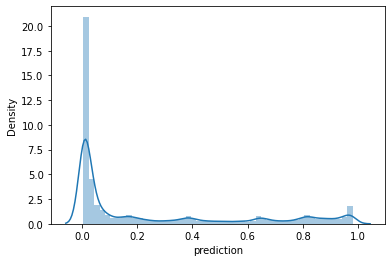

In [24]:
def plot_submission(df):  
    sns.distplot(df['prediction'])
    print(df['prediction'].describe())
    print(len(df[df['prediction']>0.95]))
    plt.show()

plot_submission(submission)

In [25]:
# submission['prediction'] *= .99
# submission.to_csv('submission.csv',index=FaAalse)

In [26]:
# submission['prediction'] /= 0.99
# submission.to_csv('submission.csv',index=False)

In [27]:
# plot_submission(submission)